# Semester Project - Continuous time paradigm in Digital Signal Processing investigation

Continuous-Time Digital Signal Processing is a signal processing paradigm that allows the discretization of a signal, working only by means of amplitude quantization. The discrete signal remains continuous in time in the digital domain, allowing a number of advantages from a digital processing point of view, such as removed aliasing phenomena and reduction of quantization error. It has been shown how this method can be achieved with “event-driven” control systems using level-crossing sampling, amplitude quantization and input signal decomposition.

This notebook contains the complete analysis and investigation done on the topic throughout the semester, following these main steps:

1. **Continuous time simulation with oversampling**: a simulation of continuous time signals with an oversampling approach and comparison of the spectral effects of quantization only and quantization+sampling
2. **Theoretical quantization approach**: quantization of a sinusoidal signal realized on a theoretical basis with Fourier series reconstruction
3. **Amplitude sampler**: generalization of the previous step to an arbitrary signal with the construction of an optimized amplitude sampler
4. **Binary wave and FIR reconstruction**: construction of the quantized signal with binary bit waves and performance of multiple FIR for reconstruction




⚠️Before starting⚠️
Make sure you have installed all the following packages and you have all the necessary Python files contained in the repository!

In [111]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

from scipy import signal, fft
from scipy.optimize import brentq
from scipy.signal import find_peaks


In [288]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex
from functions import amplitude_sampler

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Continuous time simulation with oversampling

In oder to show the effect of combined quantization and sampling on arbitrary signal, one must first try to recreate a signal that is close to continuos time as possible.
The easiest, yet not highly efficient way to do this, is to oversample the signal with an extremely high sampling frequency, resulting in a significantly small signal precision.

Let's try this first with an easy signal, a sinusoidal wave, but different signal examples can be found in the relative notebook.
We start by defining the time vector, given a finite duration and the chosen sampling frequency

In [114]:
# frequency settings
f_wave = 1000 # Hz
fsmp_ct = 120000
fsmp_1 = 44100;

# duration
n_periods = 1000;
duration= n_periods*1/f_wave
xlimit = 2/f_wave

In [115]:
print("Frequency of the sinusoid: ", f_wave, "Hz")
print("Period of the sinusoid: ", 1/f_wave, "s")
print("Over-Sampling frequency: ", fsmp_ct, "Hz")
print("Duration of the sinusoid: ", duration, "s")

Frequency of the sinusoid:  1000 Hz
Period of the sinusoid:  0.001 s
Over-Sampling frequency:  120000 Hz
Duration of the sinusoid:  1.0 s


In [116]:
# continuous time wave
t_ct = functions.time_vector(fsmp_ct, duration) # continuous time vector
s = signals_ex(t_ct, f_wave)                    # define test waveform
x_ct = s.cosine(amp = 0.8)

# sampled wave
t_smp1 = functions.time_vector(fsmp_1, duration) #sampled time vector
s = signals_ex(t_smp1, f_wave)
x_smp1= s.cosine(amp = 0.8)

print("Length of continuous time signal : ", len(t_ct), len(x_ct))
print("Length of sampled signal: ", len(t_smp1), len(x_smp1))

Length of continuous time signal :  120000 120000
Length of sampled signal:  44100 44100


Let's see how the "continuous" time signal and the sampled one look like:

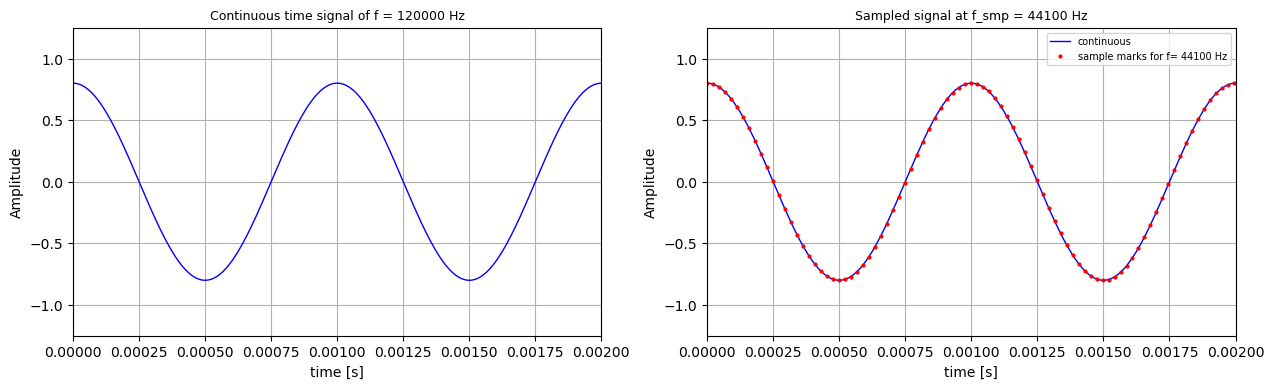

In [117]:
fig = plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous signal', col='b')
plt.title('Continuous time signal of f = %d Hz' %(fsmp_ct),fontsize = 9)

plt.subplot(1,2,2)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous', col= 'b')
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fsmp_1))
plt.title('Sampled signal at f_smp = %d Hz' %(fsmp_1),fontsize = 9)
plt.legend(prop={'size': 7})

#### Quantization of CT signal
Now, we perform quantization on both signals, using a mid-tread quantizer with a total number of steps $N = 2^{N_{bits}} -1$.


In [118]:
q = functions.quantizer(5)

x_q = q.quantize(x_ct)        # CT signal
x_q_smp1 = q.quantize(x_smp1) # SMP signal

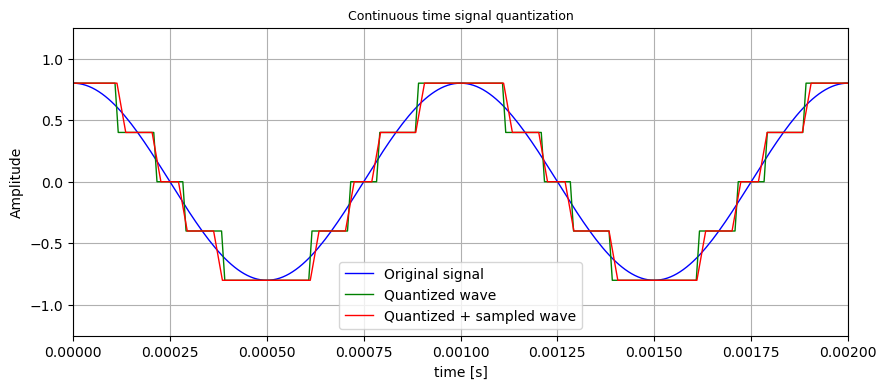

In [119]:
fig = plt.figure(figsize = (10,4))
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_ct, x_q, xlimit, ylim=1.25,label='Quantized wave',col='g' )
utils.plot_wave(t_smp1, x_q_smp1, xlimit, ylim=1.25,label='Quantized + sampled wave',col='r' )
plt.title('Continuous time signal quantization',fontsize = 9)
plt.legend()


In the figure, we can see how the quantized + sampled curve in red has some imperfections, mostly as the transitions point between two levels don't match, causing a slope to the vertical step.

We can further see the flaws of the quantized + sampled wave, comparing the spectral analysis of the three signals in question.

In [120]:
# Fourier analysis
freq_ct, X_ct = utils.fourier_analysis(x_ct, fsmp_ct)
freq_q, X_q = utils.fourier_analysis(x_q, fsmp_ct)
freq_q_smp1, X_q_smp1 = utils.fourier_analysis(q.quantize(x_smp1), fsmp_1)

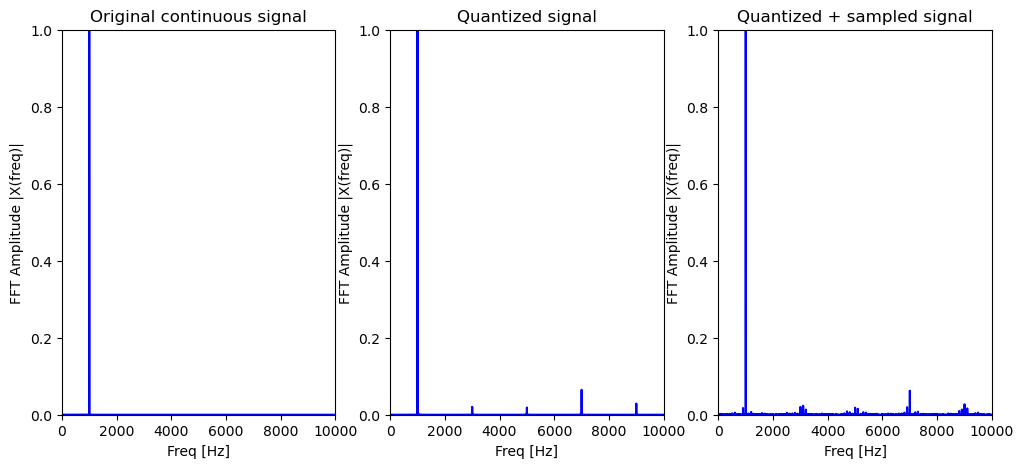

In [121]:
# linear plot
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot(freq_ct, X_ct, freq_lim=10000, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot(freq_q, X_q, freq_lim=10000, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot(freq_q_smp1, X_q_smp1, freq_lim=10000, title="Quantized + sampled signal")

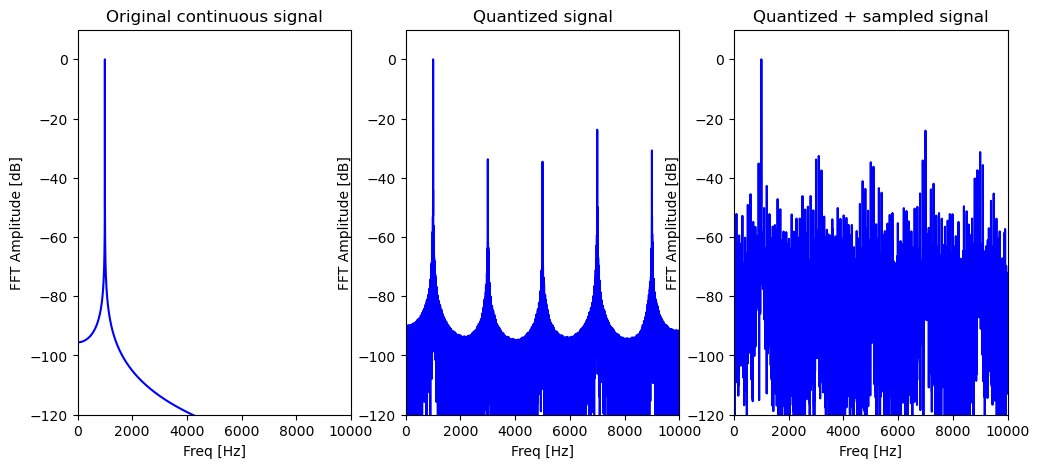

In [122]:
# dB plot
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot_db(freq_ct, X_ct, freq_lim=10000, ylim=-120, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot_db(freq_q, X_q, freq_lim=10000, ylim= -120, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot_db(freq_q_smp1, X_q_smp1, freq_lim=10000, ylim=-120,title="Quantized + sampled signal")

It's worth noting the anomalous spectral behaviour showing in both of the processed signlas: multiple odd harmonics are now present in the frequency spectrum, caused by the non-linear characteristic of the quantization.
In the quantized + sampled signal, a significant number of spurious frequencies is also added, causing a very noisy and messy spectra, from which the reconstruction process might heavily suffer in terms of aliasing.

Within this problem lies the interest for a quantization-only method.

## 2. Theoretical Quantization

The oversampling method is helpful to visualize the spectral effects of sampling on a quantized signal, but it is a very computationally heavy task. The higher the frequency of our signal is, the higher the sampling frequency will have to be in order to, first, satisfy the Nyquist criterion, and ,secondly, to achieve a sufficient number of points to mimic the continuous time behaviour, i.e. a smooth and continuous curve.
The reference article presents a theoretical approach to perform a CT quantization to a specific category of deterministic symmetric inputs, of which we will consider the simple case of a symmetric sinusoidal input:

The input signal must have a maximum amplitude that mantains the odd symmetry in the transfer characteristic. In this case, using a 3 bit mid-tread quantizer normalized to $[-1,+1]$, this can be achieved by imposing an upper bound to the amplitude as:
$x_{max} = \left(1 - \frac{1}{2^N} \right)$

For this class of inputs, then, the output of the quantizer can be rewritten as a one-sided Fourier sum:
\begin{math}
\large q( t) =  \sum_{n=1}^{\inf} c(n) sin(2\pi \frac{1}{T}\cdot n \cdot t)
\end{math}
where the Fourier coefficients are found to be given by:
\begin{math}
\large c(n) = \frac{4\Delta}{\pi n} sin\left(\frac{\pi}{2}n\right)\sum_{n=1}^{N_{steps}} sin ( d_i \cdot \pi \cdot n )
\end{math}

In the previous equation, we have a few more elements that are defined according to a specific formula:
- the **number of steps** $N_{steps}$ above 0 utilized in the first half-cycle: $ N_{ steps} = min \left( 2^{N-1}, int \left( \frac{A + 0.5\Delta}{\Delta}\right) \right) $
- the **duty cicle** $d_i$, related to the duration of time that the input signal spends above the ith positive quantization level boundary when looking at the first half cycle of the input, found as $ d_i = \frac{1}{2} - \frac{1}{\pi} \text{sin}^{-1} \left( \frac{(2i - 1)\Delta}{2A}\right) $

In [123]:
class theory_class:
    # implement the theory parameters of the quantizer with N quantization bits, defined for a sinusoidal input.

    def __init__(self, N):
        self.NBits = N
    def x_max(self):
        # maximum amplitude
        xmax = 1 - 1 / (2 ** self.NBits)
        return xmax
    def step_size(self):
        # size of the quantization steps
        delta_step = (2) / (2 ** (self.NBits))
        return delta_step

    def num_steps(self,amp,delta):
        # number of possible quantizer steps on a half-cycle
        # amp:  amplitude of the signal
        # delta: size of the step
        a = 2 ** (self.NBits- 1) - 1
        b = int((amp + 0.5 * delta) / delta)
        N = np.minimum(a, b)
        return N

In [124]:
def duty(D, amp, n):
    '''
    :param D: delta size of the steps
    :param amp: amplitude of the signal
    :param n: number of steps
    :return: list of the duty cycles of each quantizer level
    '''
    d = np.zeros(n+1)
    for i in range(1,n+1):
        d[i] = 1/2 - (1/np.pi)*np.arcsin((2*i-1)*D/(2*amp))
    return d

def threshold(n, D):
    '''
    :param n: number of steps
    :param D: delta size of the steps
    :return: height y-value of each quantizer step
    '''
    x = np.zeros(n+1)
    for i in range(1,n+1):
        x[i] = D*((2*i-1)/2)
    return x

In [125]:
#---------signal specifics---------------
f = 1000
f_smp = f*100
n_periods=1000
dur=n_periods*1/f
T=1/f
T_smp = 1/f_smp
#----------------------------------------
t= np.linspace(0,dur, int(np.ceil(dur/T_smp)))
sin_wave = np.sin(2*np.pi*f*t)

#--------------------------------------------
print("Duration of the signal is: ", dur, "s")
print("The period of the signal is: ", T, "s")
print("Length of the time vector is: ", len(t), "samples")

Duration of the signal is:  1.0 s
The period of the signal is:  0.001 s
Length of the time vector is:  100000 samples


In [126]:
N_qbits = 3;
th  = theory_class(N_qbits)

delta = th.step_size()
A = th.x_max()
N_steps = th.num_steps(A, delta)

#-----------------------------------------------
print("The max amplitude of the signal is: ", A)
print("The size of the step is: ", delta)
print("The number of steps in a half-cycle is: ", N_steps)

The max amplitude of the signal is:  0.875
The size of the step is:  0.25
The number of steps in a half-cycle is:  3


In [127]:
dc = duty(delta, A, N_steps)[1:]
print("Lenght of duty cicles: {}".format(dc))
x_t = threshold(N_steps, delta)[1:]
print("Height of thresholds: {}".format(x_t))

Lenght of duty cicles: [0.45437105 0.35901704 0.24675171]
Height of thresholds: [0.125 0.375 0.625]


In [128]:
# Fourier coefficients
def c_n(D, nsteps, dc, n_idx):
    '''
    :param D: delta size of the steps
    :param nsteps: number of steps
    :param dc: duty cycle list
    :param n_idx: index of the coefficient

    :return: n_th coefficient value
    '''
    cn = 0
    for i in range(1,nsteps+1):
        tmp = (4*D)/(np.pi*n_idx)*np.sin(np.pi*n_idx/2)*np.sin(np.pi*n_idx*dc[i-1])
        cn = cn + tmp
    return cn

# Fourier series
def q_out (D, nsteps, dc, T, t, k):
    '''
    :param D: delta size of the steps
    :param nsteps:number fo steps
    :param dc: duty cycle list
    :param T: period of the signal
    :param t: time vector
    :param k: number of harmonics

    :return: quantized signal as Fourier sum
    '''
    q_out = np.zeros(len(t))
    for i in range(1, k):
        tmp = c_n(D, nsteps, dc, i)*np.sin(2*np.pi*i/T*t)
        q_out = q_out + tmp
    return q_out

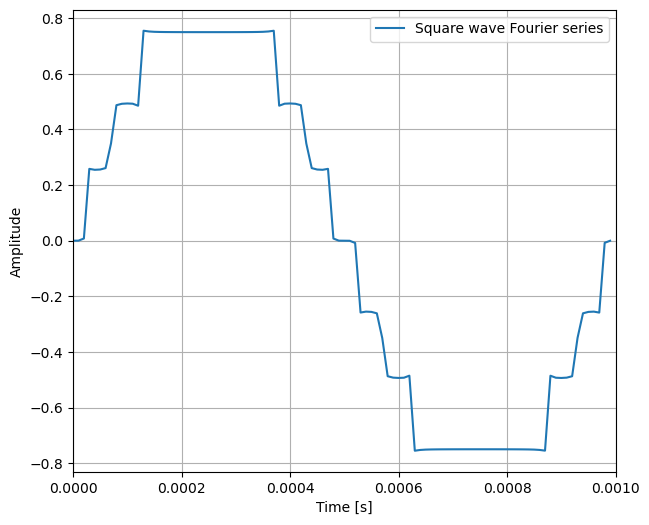

In [129]:
k = 100
c_n(delta, N_steps, dc, 1)
q_th = q_out(delta, N_steps, dc, T, t[0:100], k)
#--------------------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(t[0:100], q_th[0:100], label = 'Square wave Fourier series')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.legend()
plt.xlim(0,T)
plt.grid()
#--------------------------------------------------------------------
q_th = np.tile(q_th, n_periods) # repeat square wave for frequency analysis

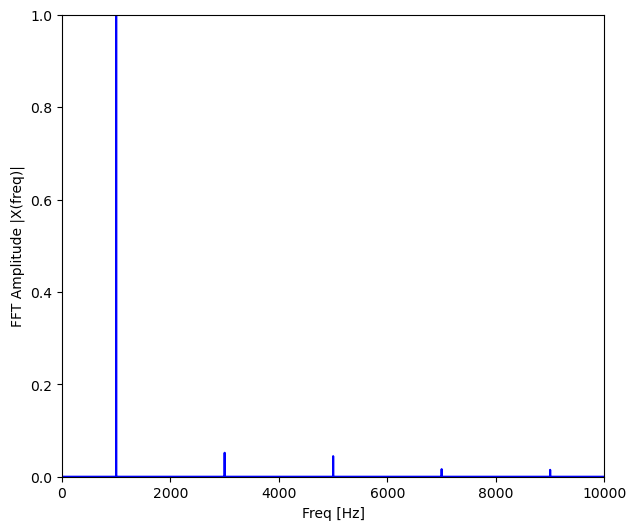

In [130]:
# Fourier frequency analysis
freq_th, X_th = utils.fourier_analysis(q_th, f_smp)
plt.figure(figsize=(7,6))
utils.fourier_plot(freq_th, X_th, freq_lim = 10000, title= "")

## 3. Amplitude sampler
The previous section showed a theoretical approach to construct the quantized signal, limiting it only to the case of sinusoidal inputs. But how can we generalize this method to any kind of signal wave?

In this section, we simulate an algorithm purely based on the principle of amplitude sampling, that does not require the simulation of a wave continuous in time. This is not only helpful for the matter of computational costs, that were ignored when using the oversampling method, but it is also very efficient as it works with a more shallow level of the time precision of the crossing instants.

The amplitude sampler algorithm works following these steps:
- the function takes as input the signal function, its period, the mid-tread quantizer function and a sampling grid to define the sample points per period
- from the quantizer, we get the indices of the quantized function going from 0 (the lowest possible y value) to highest equal to $(2^{N_{bits}}-1)-1$
- iterating over the sample grid, we check for a level transition comparing the bin index of two following grid points
- if a transition has occurred, first determine the threshold value for the amplitude crossing, and then find the exact crossing time between the two neighbouring samples using the <code style="font-family: 'Courier New', monospace;">brentq </code>  optimizer from scipy

Let's see how the amplitude sampler performs:

In [131]:
#---------------------------------------
T = 1
t_range = np.linspace(0,T,1000)
q = functions.quantizer(5)
#---------------------------------------
t_inst, q_idx = amplitude_sampler(functions.test_func, T, q) # finds transition instants
bin_step = q.qvalue(q_idx) # find the step value of each bin
#----------------------------------------------------
print('Transition instants: {}'.format(t_inst))
print('Bins index: {}'.format(q_idx))
print('Bins step value: {}'.format(bin_step))

Transition instants: [0.         0.1115502  0.17861206 0.2380546  0.30511647 0.52821686
 0.59527873 0.65472127 0.72178314 0.94488353]
Bins index: [4 3 2 1 0 1 2 3 4 3]
Bins step value: [ 0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8  0.4]


The following tests show that the transition points are independent of the initial density of the grid. As long as the grid is not too sparse, we are able to obtain the crossing instants efficiently with fewer points

In [132]:
print(" 10000 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=10000)[0][0:5]))
print(" 100 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=100)[0][0:5]))

 10000 points per period grid: [0.         0.1115502  0.17861206 0.2380546  0.30511647]
 100 points per period grid: [0.         0.1115502  0.17861206 0.2380546  0.30511647]


In [133]:
try:
    amplitude_sampler(functions.test_func, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


Once the transition instants are found, we can define the multiple "pulses" that construct the quantized signal. Note that these are not step like functions corresponding to the duty-cycle duration of each step, but rather pulses that share the same starting point, and each have a delayed ending, according the relative transition instant

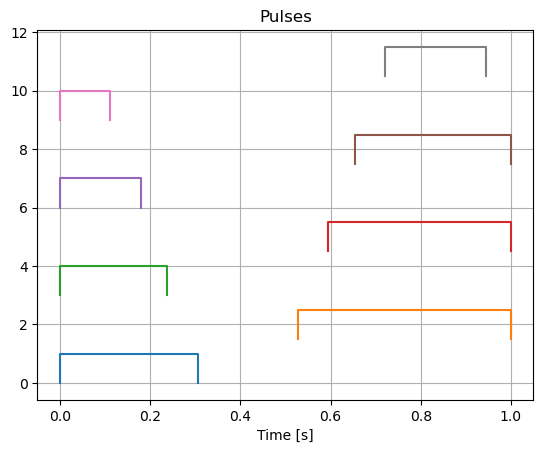

In [139]:
functions.decompose(t, q_idx, T)
n = 0
for p in functions.decompose(t, q_idx, T):
    plt.plot([p[0], p[0], p[1], p[1]], [n, n + 1, n + 1, n])
    n += 1.5
plt.grid()
plt.title("Pulses decomposition")
plt.xlabel("Time [s]")
plt.show()

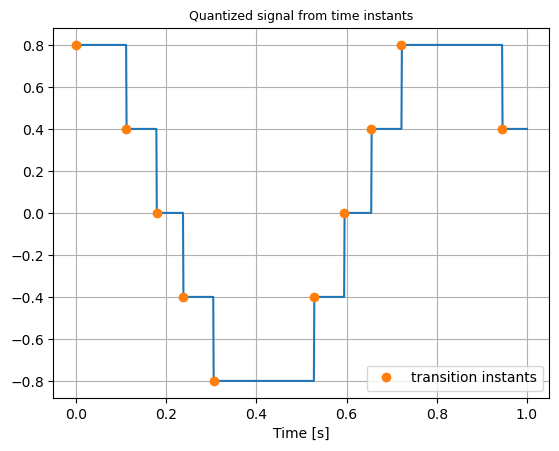

In [141]:
pulse_times = functions.decompose(t, q_idx, T)
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
plt.plot(t, bin_step, 'o', label='transition instants')
plt.title("Quantized signal from time instants", fontsize=9)
plt.xlabel("Time [s]")
plt.legend()
plt.grid()

Following a similar approach to the previous section, starting from the previous decomposition, we can reconstruct the signal using a Fourier series specifically taylord for our pulses functions. Indeed, knowing the crossing instants at the beginning and end of the pulse, namely $t_0$ and $t_1$, and assuming a period of $T$, we find the Fourier series to be as follows:

\begin{math}
\Large f ( x ) =  \sum_n c_{n} e^{j 2 \pi \frac{n}{T} x }
\end{math}


with coefficients $C_n$:
\begin{math}
\Large c_n = \frac{1}{\pi n} e^{-j 2 \pi n \frac{t}{T} \frac{t_{0} + t_{1}}{2} } \text{sin} ( 2 \pi n \frac{t}{T} \frac{t_{1} - t_{0}}{2} )

\end{math}

In [136]:
# Fourier Series
def FS(n, t0,t1, T, t, delta):
    '''
    :param n: number of harmonics
    :param t0: start time instant
    :param t1: end time instant
    :param T: signal period
    :param x: time vector
    :param delta: step size

    :return: one-sided Fourier sum for one step function
    '''
    F=0
    for i in range(1,n):
        c = 1/(np.pi*i) * (np.exp(-1j*2*np.pi*i/T*(t0+t1)/2)*np.sin(2*np.pi*i/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*i*t/T)
        F = F + F_tmp
    return F

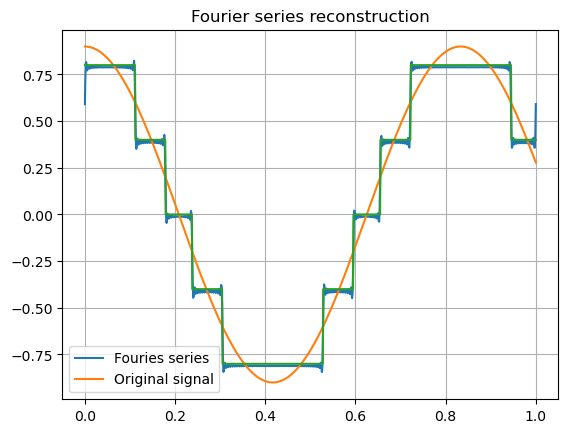

In [142]:
FS_complete = 0
x = np.linspace(0, T, 1000)                   # time vector
pulse_times= functions.decompose(t, q_idx, T) # pulse time intervals

# sum all the step functions together
for i in range(len(pulse_times)):
    F_tmp = FS(200, pulse_times[i][0], pulse_times[i][1],T, x, q.step*2)
    FS_complete = FS_complete + F_tmp

#----------------------------------------------------------------
plt.plot(x, FS_complete + 0.1, label="Fouries series")
plt.plot(x, functions.test_func(x), label= "Original signal")
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
plt.title("Fourier series reconstruction")
plt.legend()
plt.grid()


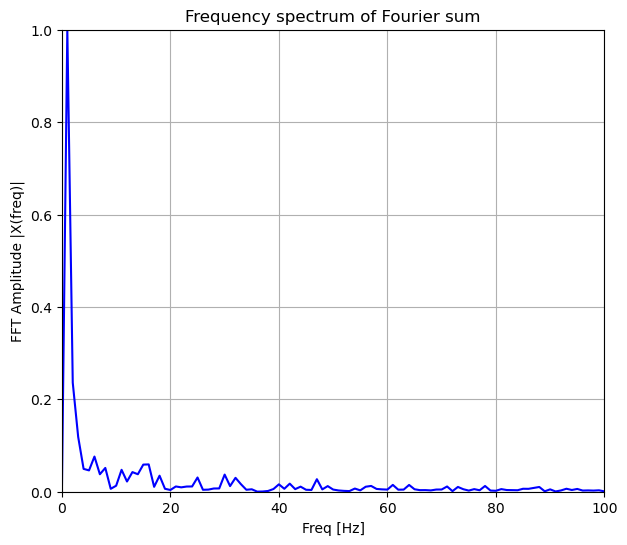

In [348]:
# Fourier frequency analysis
freq_FS, X_FS = utils.fourier_analysis(FS_complete, fsmp = 1000)
#---------------------------------------------------------
plt.figure(figsize=(7, 6))
utils.fourier_plot(freq_FS, X_FS, freq_lim=100, title="Frequency spectrum of Fourier sum")

#### Other test

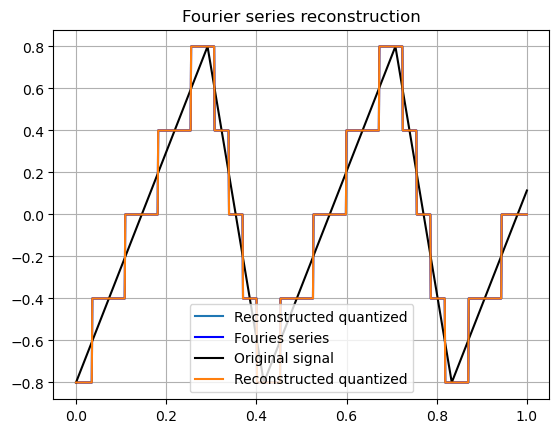

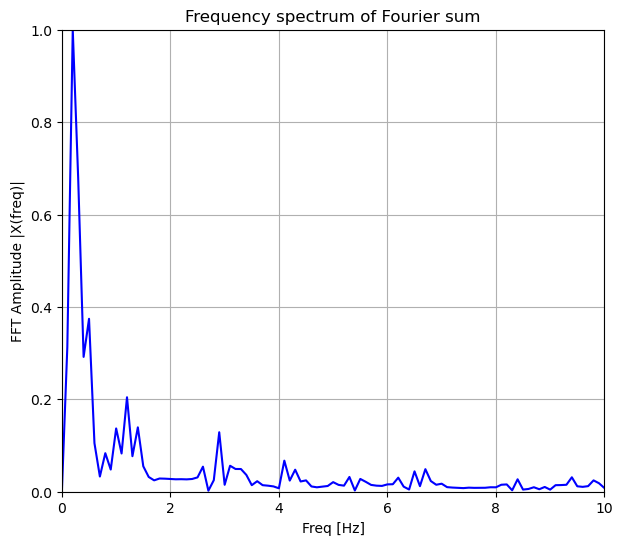

In [371]:
import amplitudeSampling
def new_test(x):
    f0 = 2.4 # Hz
    return 0.8* signal.sawtooth(2 * np.pi * f0 * x, 0.7)

amplitudeSampling.ampSmp_run(t_range,T,q, new_test)

# 4. Binary wave reconstruction
Since the number of possible levels in our quantizer system is finite, these levels can also be represented by binary words: each level of the quantized wave will be mapped to a binary number according to the number of chosen quantization bits, and the binary waves will represent the trend of a single bit over time.

![Binary words](binary_words.png)

In [333]:
def test(x):
    f0 = 1.2 # Hz
    y = 0.3 * np.sin(2 * np.pi * f0 * x) + 0.5 * np.sin(2 * np.pi * 2 * f0 * x)
    #y = np.cos(2 * np.pi * f0 * x)
    return y

In [334]:
stop_time = 1
N_qbits = 3
q = functions.quantizer(5)
#--------------------------------------
x = np.linspace(0, stop_time, 1000) #time vector
y = test(x) #create waveform

Bins index: [2 3 4 3 2 1 2 3 2 1 0 1 2 3 4 3]
Step value: [ 0.   0.4  0.8  0.4  0.  -0.4  0.   0.4  0.  -0.4 -0.8 -0.4  0.   0.4
  0.8  0.4]


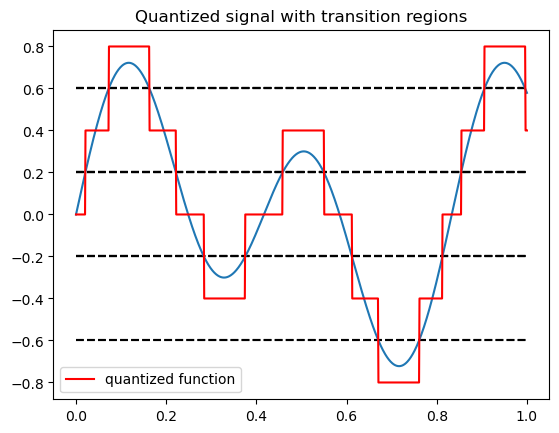

In [335]:
T = int(stop_time)
t, q_idx = amplitude_sampler(test, T, q)
a = q.qvalue(q_idx)  # find the step y value for each bin

print('Bins index: {}'.format(q_idx))
print('Step value: {}'.format(a))

#------------------------------------------------------------------------
for i in range(0,len(q_idx)-1):
    plt.hlines(q.qthreshold(q_idx[i],q_idx[i+1]), 0, 1,'black', linestyles='dashed', label='')
plt.plot(x, test(x))
plt.plot(x, q.quantize(test(x)), 'r', label='quantized function')
plt.title("Quantized signal with transition regions")
plt.legend()

In [336]:
class binary_encoder:
    # Class to encode the index of the quantization bin into a binary string
    def __init__(self, NQbits):
       self.qbits = NQbits
    def binWord(self, bin_index):
        # Convert to binary string, removing the '0b' prefix
        # Fill with zeros to have a fixed length of Nqbits
        binary_list = []
        for i in range(0,len(bin_index)):
            binary_str = bin(bin_index[i])[2:].zfill(self.qbits)
            binary_list.append(binary_str)
        return binary_list

    def bit_extract(self, bi_list, bit_pos):
        # get only the specified position bit
        singlebit = np.array([int(bits[bit_pos]) for bits in bi_list], dtype=int)
        return  singlebit

    def bitmat(self, bi_list):
        # generates a matrix where each row represents a position bit
        mat = np.zeros(( self.qbits,len(bi_list)))
        for i in range(self.qbits):
            mat[i,:] = self.bit_extract(bi_list, i)
        return mat

    def plot_bitmat(self, mat, x, transitions):
        mat_plot = np.zeros(( self.qbits,len(x)))
        t_round = np.append(np.round(transitions,3), np.ceil(transitions[-1]))
        for i in range(self.qbits):
            current_row = mat[i,:]
            current_rowplot = mat_plot[i,:]

            for j in range(len(current_row)):
                if current_row[j] == 1:
                    current_rowplot[int(t_round[j]*1000) : int(t_round[j+1]*1000)] = 1

            mat_plot[i,:] = current_rowplot
        return mat_plot

    def plot_bit(self, mat, transitions, x):
        n_rows = self.qbits
        n_cols = len(x)
        plot_mat= np.zeros((n_rows, n_cols), dtype=int)

        for i in range(self.qbits):
            row = mat[i, :]
            plot_row = plot_mat[i, :]
            t_round = np.round(transitions,3).copy()

            for j in range(len(row)):
                if row[j] == 1:
                    plot_row[int(t_round[j] * n_cols):int(t_round[ + 1] * n_cols)] = 1
            plot_mat[i, :] = plot_row
        return plot_mat


In [337]:
binEnc = binary_encoder(NQbits = 3)
word_list= binEnc.binWord(q_idx)
word_mat = binEnc.bitmat(word_list)
#-------------------------------------
print('Bins index: {}'.format(q_idx))
print('Binary encoding: {}'.format(word_list))
print('Least significant bit: {}'.format(word_mat[2,:]))

Bins index: [2 3 4 3 2 1 2 3 2 1 0 1 2 3 4 3]
Binary encoding: ['010', '011', '100', '011', '010', '001', '010', '011', '010', '001', '000', '001', '010', '011', '100', '011']
Least significant bit: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


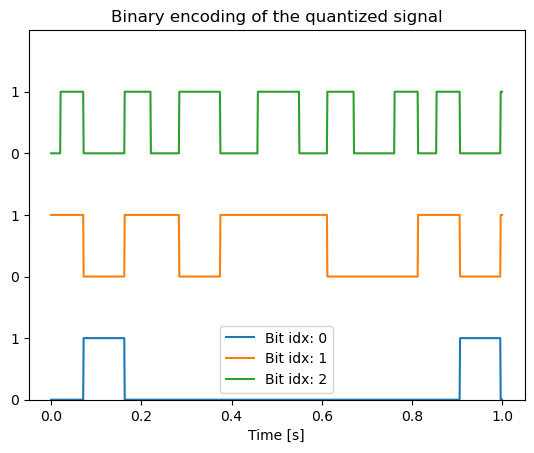

In [338]:
bitEnc = binary_encoder(NQbits = 3)
bit_mat= bitEnc.plot_bitmat(word_mat,x,t)
utils.bitmap_plotter(N_qbits, bit_mat, x)

In [315]:
print(q.step)

0.4


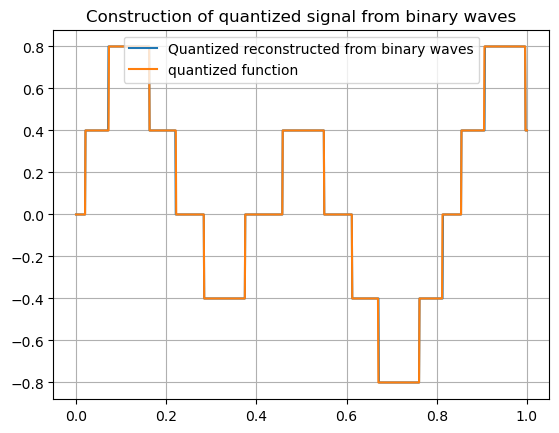

In [339]:
q_tot = 0
for i in range(1,np.shape(bit_mat)[0]+1):
    #q_temp = 2**(-i+1)*bit_mat[i-1,:]*2*q.step*2
    q_temp = 2**(N_qbits-i)*bit_mat[i-1,:]*q.step
    q_tot = q_tot + q_temp

plt.plot(x, q_tot - q.step*2, label='Quantized reconstructed from binary waves')
plt.plot(x, q.quantize(test(x)), label='quantized function')
plt.title("Construction of quantized signal from binary waves")
plt.grid()
plt.legend()

# to do
- Create pipeline function for amplitude sampling + reconstruction
- create pipeline for quantization
- create pipeline for FIR

- CT from article can be deleted ?
- basic quantization with other functions

!! polynomial function !!

